In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

/home/qazw5741/miniconda3/envs/SAM/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [4]:
import glob
import scipy.io as scio
import os
joints = scio.loadmat(os.path.join('/database/changhee/HR-LSPET/hr-lspet','joints.mat'))['joints'].transpose(2,0,1).astype(np.float32)
img_paths = glob.glob(os.path.join('/database/changhee/HR-LSPET/hr-lspet', '*.png'))

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/qazw5741/segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [21]:
one_joints,one_img_path=joints[10],sorted(img_paths)[10]

In [22]:
one_img_path

'/database/changhee/HR-LSPET/hr-lspet/im00011.png'

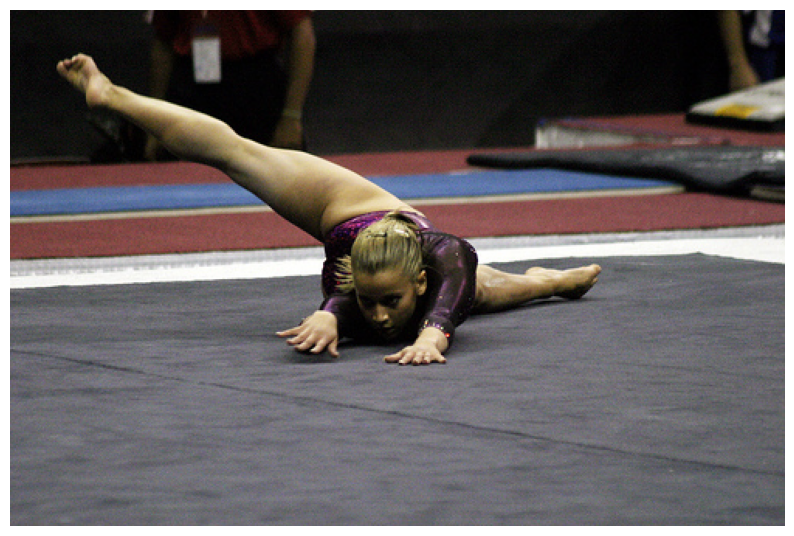

In [23]:
image = cv2.imread(one_img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.savefig("./assets/LSP_input1.jpg",bbox_inches='tight', pad_inches=0)
plt.show()

In [24]:
predictor.set_image(image)

In [25]:
one_joints[:,2]=1

In [26]:
input_point = one_joints[:,:2]
input_label = one_joints[:,2]

In [27]:
input_label

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

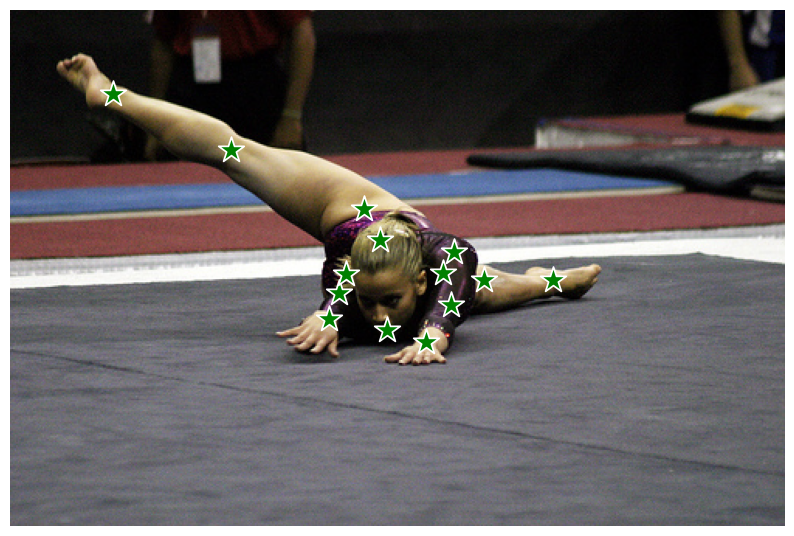

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.savefig("./assets/LSP_2d_input1.jpg",bbox_inches='tight', pad_inches=0)
plt.show()  

In [29]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [30]:
masks.shape

(3, 333, 500)

In [31]:
scores

array([0.93185836, 0.9798981 , 0.9458749 ], dtype=float32)

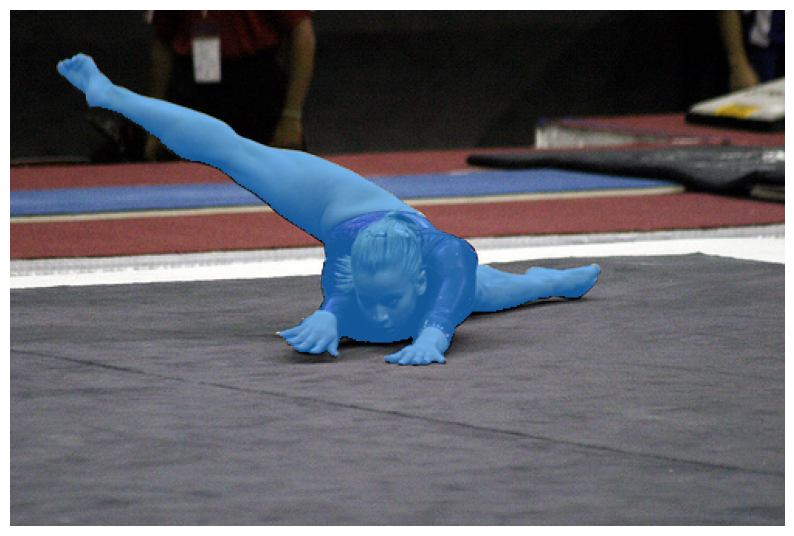

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[2], plt.gca())
plt.axis('off')
plt.savefig("./assets/LSP_mask1.jpg",bbox_inches='tight', pad_inches=0)
plt.show() 

In [17]:
from pycocotools.coco import COCO
from pycocotools import mask


In [18]:
test=mask.encode(np.asfortranarray(masks[2]))

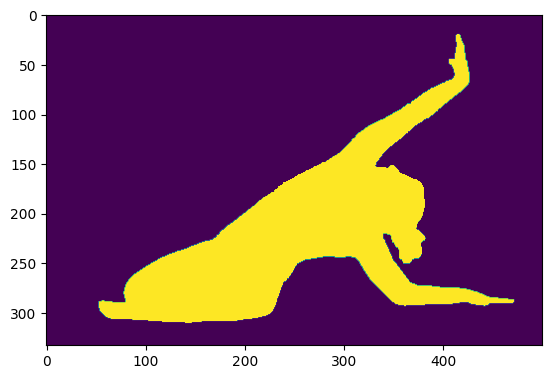

In [19]:
plt.imshow(mask.decode(test))

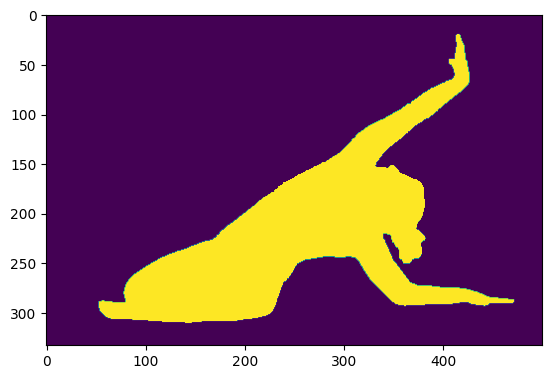

In [20]:
test['counts']=test['counts'].decode('utf-8')
plt.imshow(mask.decode(test))